# Simframe

[Simframe](https://simframe.readthedocs.io/en/latest/) is a Python framework to set up scientific simulations. Since DustPy is based in Simframe this notebook will be a short and concise tutorial on the usage and philosophy of Simframe.

Simframe allows you to easily integrate differential equations by simply providing a function returning the derivative of a quantity. The advantage is that you do not have to care about peripherals such as organizing the structure of your project or writing and reading data files. These things are dealt with by Simframe under the hood.

Consider the following simple problem that we want to solve:

$\Large \frac{\mathrm{d}}{\mathrm{d}t} Y = -bY$

with the initial condition 

$\Large Y\left( t=0 \right) = A$.

The solution of this problem is known

$\Large Y\left( t \right) = A  e^{-bt}$.

Additionally, we do not only want to integrate the quantity $Y$, but we want to also compute the quantity $T$, which depends in $Y$ via

$\Large T = - \frac{1}{b} \log \frac{Y}{A}$,

which has the simple solution $Y=t$ in this case.

## Setting up the model

In [1]:
from simframe import Frame

In [2]:
sim = Frame(description="Simple example")

In the first step we create a Simframe object, which is an empty frame to be filled by us at the moment.

In [3]:
sim

Frame (Simple example)
----------------------
    Integrator   : not specified
    Writer       : not specified

### Structuring the simulation frame

Now we can create a group to store the simulation parameters $A$, $b$, as well as or desired time step of the integration $\Delta t$.

In [4]:
sim.addgroup("pars", description="Simulation parameters")

In [5]:
sim

Frame (Simple example)
----------------------
    pars         : Group (Simulation parameters)
  -----
    Integrator   : not specified
    Writer       : not specified

Then we add the parameters to the group.

In [6]:
sim.pars.addfield("A", 10., description="Initial value of Y", constant=True)
sim.pars.addfield("b", 1., description="Decay rate", constant=True)
sim.pars.addfield("dt", 0.5, description="Time step")

In [7]:
sim.pars

Group (Simulation parameters)
-----------------------------
    A            : Field (Initial value of Y), constant
    b            : Field (Decay rate), constant
    dt           : Field (Time step)
  -----

These parameters can be easily addressed.

In [8]:
sim.pars.A

10.0

### Adding the integration variable

In the next step we add the integration variable $t$.

In [9]:
sim.addintegrationvariable("t", 0., description="Time")

In [10]:
sim

Frame (Simple example)
----------------------
    pars         : Group (Simulation parameters)
  -----
    t            : IntVar (Time), Integration variable
  -----
    Integrator   : not specified
    Writer       : not specified

The integration variable needs two additional pieces of information:  
It needs a prescription to calculate the time step it should take from the current state of the simulation frame. And it needs to know when to write output files.

To compute the time step we have to provide a functions that takes the simulation frame as input and returns the timestep. In this simple example we simply want to return the time step stored in the parameters group.

In [11]:
def dt(sim):
    return sim.pars.dt

This function it then assigned to the so-called "updater" of the integration variable, because it tells the variable how to advance itself during an integration step. 

In [12]:
sim.t.updater = dt

Now we tell the integration variable at which values it should write output files. The final value is alse the final time of the simulation.

In [13]:
import numpy as np

In [14]:
sim.t.snapshots = np.arange(1., 11., 1.)

### Adding fields to the simulation frame

Next we are going to add fields for the variables $Y$ and $T$ and initialize them with their respective values.

In [15]:
sim.addfield("Y", sim.pars.A, description="Integrated variable")
sim.addfield("T", 0., description="Updated variable")

Both variables are conceptually different: the first one is being integrated, while the second one is simply updated from the current state of the simulation frame.  
In the latter case we simply have to provide a function that takes the simulation frame as input and returns the new values of the variable.

In [16]:
def T(sim):
    return -np.log(sim.Y/sim.pars.A) / sim.pars.b

As previously, this function needs to be added to the updater of the field.

In [17]:
sim.T.updater = T

Additionally, we need to tell Simframe that it has to update this field once after every integration step. This can be done by adding the field to the updater of the simulation frame.

In [18]:
sim.updater = ["T"]

### Adding differential equations

The field $Y$ is not updated, but integrated. We therefore have to provide a function that returns the derivative of the field. This function needs in addition to the simulation frame also the integration variable and the field itself as input parameters.

In [19]:
def dYdt(sim, t, Y):
    return -sim.pars.b*Y

Instead of adding this function the updater, we have to add it to the "differentiator" of the field.

In [20]:
sim.Y.differentiator = dYdt

### Setting up the integrator

In the next step we need to add an integrator to the simulation, which tells Simframe what needs to be integrated and how to do it. The integrator needs to be initialized with the integration variable that is relevant for this problem.

In [21]:
from simframe import Integrator

In [22]:
sim.integrator = Integrator(sim.t)

And we need to give the integrator a list of integration instructions that tell it, what variable needs to be integrated with which integration scheme. In this example we are using a simple explicit Euler first order scheme.

In [23]:
from simframe import Instruction
from simframe import schemes

In [24]:
sim.integrator.instructions = [
    Instruction(schemes.expl_1_euler, sim.Y)
]

### Configuring the writer

In the last step we can tell Simframe how to writer output files. This is not strictly necessary. We could also run the simulation without writing any files. In this example we want to writer output files in the .hdf5 file format.

In [25]:
from simframe import writers

In [26]:
sim.writer = writers.hdf5writer()

We change the name of the datadirectory and allow Simframe to overwrite existing files.

In [27]:
sim.writer.datadir = "simframe"
sim.writer.overwrite = True

## Running the simulation

The simulation frame is now fully configured.

In [28]:
sim

Frame (Simple example)
----------------------
    pars         : Group (Simulation parameters)
  -----
    t            : IntVar (Time), Integration variable
    T            : Field (Updated variable)
    Y            : Field (Integrated variable)
  -----
    Integrator   : Integrator
    Writer       : Writer (HDF5 file format using h5py)

We can start the simulation.

In [29]:
sim.run()

Creating data directory 'simframe'.
Writing file simframe/data0000.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0001.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0002.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0003.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0004.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0005.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0006.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0007.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0008.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0009.hdf5
Writing dump file simframe/frame.dmp
Writing file simframe/data0010.hdf5
Writing dump file simframe/frame.dmp
Execution time: 0:00:00


## Reading data files

Data files can be read with the same writer class from which the data files are written.

In [30]:
wrtr = writers.hdf5writer(datadir="simframe")

One possibility is to read the entire dataset. This is fine for small projects. But typical DustPy simulation would require to read several gigabytes when read completely, which may not be feasible.

In [31]:
data = wrtr.read.all()

Another option is to read a single snapshot with

In [32]:
data0008 = wrtr.read.output(8)

And the third method is to read all snapshots of a single field.

In [33]:
t = wrtr.read.sequence("t")
T = wrtr.read.sequence("T")
Y = wrtr.read.sequence("Y")

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

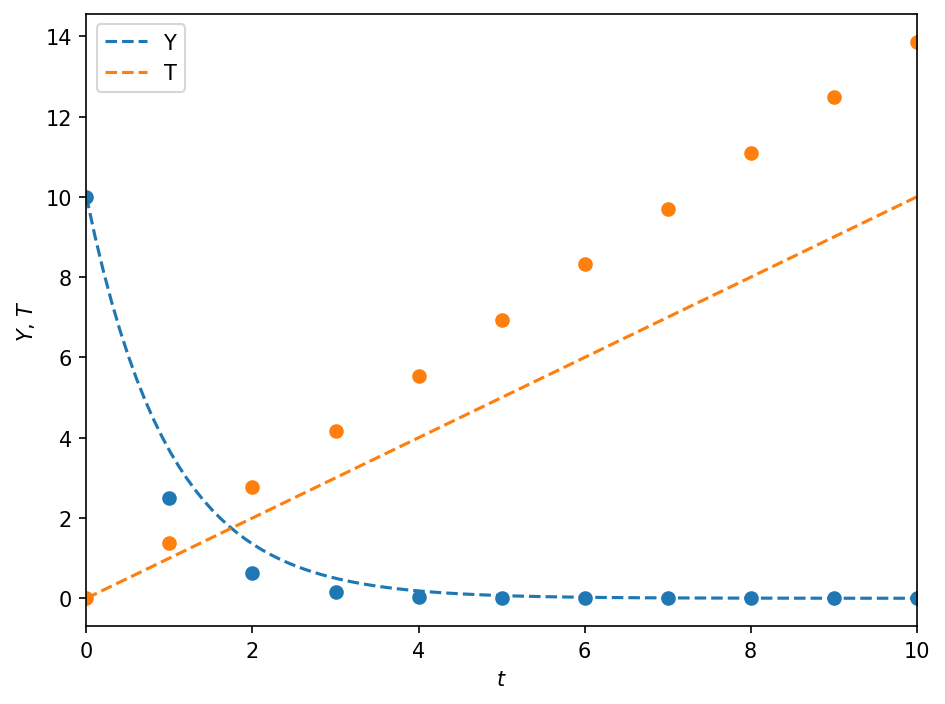

In [35]:
tt = np.linspace(t.min(), t.max(), 100)
fig, ax = plt.subplots()
ax.plot(t, Y, "o", c="C0")
ax.plot(t, T, "o", c="C1")
ax.plot(tt, sim.pars.A*np.exp(-sim.pars.b*tt), "--", c="C0", label="Y")
ax.plot(tt, tt, "--", c="C1", label="T")
ax.set_xlabel("$t$")
ax.set_ylabel("$Y$, $T$")
ax.set_xlim(t.min(), t.max())
ax.legend()
fig.tight_layout()

## Do-it-yourself

There are obviously deviations from the analytical solutions. These are purely of numerical origin.  
Try to improve it by
1. reducing the time step $\Delta t$
2. using a higher-order integration scheme e.g. classical Runge-Kutta 4th order